# How to save and load parameters of an augmentation pipeline

Reproducibility is very important in deep learning. Data scientists and machine learning engineers need a way to save all parameters of deep learning pipelines such as model, optimizer, input datasets, and augmentation parameters and to be able to recreate the same pipeline using that data. Albumentations has built-in functionality to serialize the augmentation parameters and save them. Then you can use those parameters to recreate an augmentation pipeline.

### Import the required libraries

In [ ]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

### Define the visualization function

In [ ]:
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)

### Load an image from the disk

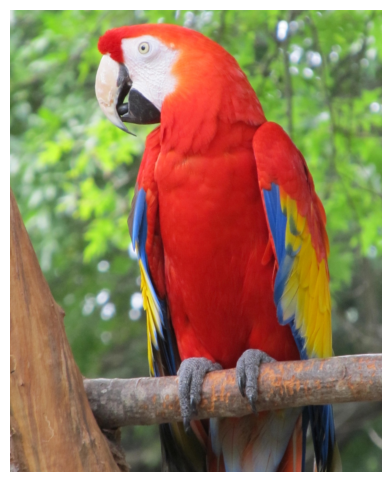

In [ ]:
image = cv2.imread('images/parrot.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

### Define an augmentation pipeline that we want to serialize

In [ ]:
transform = A.Compose([
    A.Perspective(),
    A.RandomCrop(768, 768),
    A.OneOf([
        A.RGBShift(),
        A.HueSaturationValue()
    ]),
])

We can pass an instance of augmentation to the `print` function, and it will print the string representation of it.

In [ ]:
print(transform)

Compose([
  Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


Next, we will fix the random seed to make augmentation reproducible for visualization purposes and augment an example image.

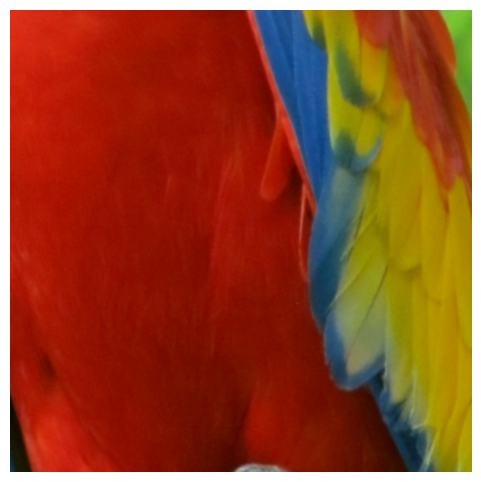

In [ ]:
random.seed(42)
np.random.seed(42)
transformed = transform(image=image)
visualize(transformed['image'])

## Serializing an augmentation pipeline to a JSON or YAML file

To save the serialized representation of an augmentation pipeline to a JSON file, use the `save` function from Albumentations.

In [ ]:
A.save(transform, '/tmp/transform.json')

To load a serialized representation from a JSON file, use the `load` function from Albumentations.

In [ ]:
loaded_transform = A.load('/tmp/transform.json')

In [ ]:
print(loaded_transform)

Compose([
  Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


Next, we will use the same random seed as before and apply the loaded augmentation pipeline to the same image.

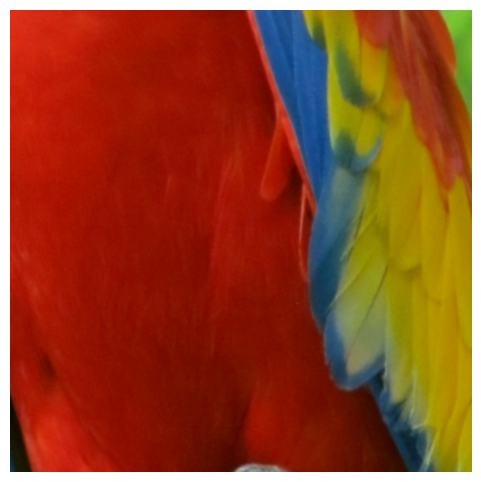

In [ ]:
random.seed(42)
transformed_from_loaded_transform = loaded_transform(image=image)
visualize(transformed_from_loaded_transform['image'])

In [ ]:
assert np.array_equal(transformed['image'], transformed_from_loaded_transform['image'])

As you see, it produced the same result.

#### Using YAML insted of JSON

You can also use YAML instead of JSON for serializing and deserializing of augmentation pipelines. To do that add the `data_format='yaml'` argument to  the `save` and `load` functions.

In [ ]:
A.save(transform, '/tmp/transform.yml', data_format='yaml')
loaded_transform = A.load('/tmp/transform.yml', data_format='yaml')

In [ ]:
print(loaded_transform)

Compose([
  Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


## Serializing an augmentation pipeline to a Python dictionary

If you need more control over a serialized pipeline, e.g., you want to save a serialized version to a database or send it to a server you can use the `to_dict` and `from_dict` functions. `to_dict` returns a Python dictionary that describes a pipeline. The dictionary will contain only primitive data types such as dictionaries, lists, strings, integers, and floats. To construct a pipeline from a dictionary, you need to call `from_dict`.

In [ ]:
transform_dict = A.to_dict(transform)
loaded_transform = A.from_dict(transform_dict)

In [ ]:
print(loaded_transform)

Compose([
  Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1),
  RandomCrop(always_apply=False, p=1.0, height=768, width=768),
  OneOf([
    RGBShift(always_apply=False, p=0.5, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
    HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  ], p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


## Serializing and deserializing Lambda transforms

Lambda transforms use custom transformation functions provided by a user. For those types of transforms, Albumentations saves only the name and the position in the augmentation pipeline. To deserialize an augmentation pipeline with Lambda transforms, you need to manually provide all Lambda transform instances using the `lambda_transforms` argument.

Let's define a function that we will use to transform an image. 

In [ ]:
def hflip_image(image, **kwargs):
    return cv2.flip(image, 1)

Next, we create a Lambda transform that will apply the `hflip_image` function to input images. Note that to make the transform serializable, you need to pass the `name` argument.

In [ ]:
hflip = A.Lambda(name='hflip_image', image=hflip_image, p=0.5)
transform = A.Compose([hflip])
print(transform)

Compose([
  Lambda(name='hflip_image', image=<function hflip_image at 0x2a7e34d30>, mask=<function noop at 0x13a7c0d30>, keypoint=<function noop at 0x13a7c0d30>, bbox=<function noop at 0x13a7c0d30>, always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


To check that transform is working, we will apply to an image.


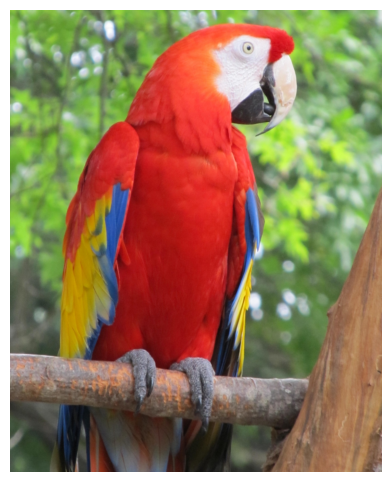

In [ ]:
random.seed(7)
transformed = transform(image=image)
visualize(transformed['image'])

To serialize a pipeline with a Lambda transform, use the `save` function as before.

In [ ]:
A.save(transform, '/tmp/lambda_transform.json')

To deserialize a pipeline that contains Lambda transforms, you need to pass names and instances of all Lambda transforms in a pipeline through the `lambda_transforms` argument.

In [ ]:
loaded_transform = A.load('/tmp/lambda_transform.json', nonserializable={'hflip_image': hflip})

In [ ]:
print(loaded_transform)

Compose([
  Lambda(name='hflip_image', image=<function hflip_image at 0x2a7e34d30>, mask=<function noop at 0x13a7c0d30>, keypoint=<function noop at 0x13a7c0d30>, bbox=<function noop at 0x13a7c0d30>, always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


Verify that the deserialized pipeline produces the same output.

In [ ]:
random.seed(7)
transformed_from_loaded_transform = loaded_transform(image=image)
assert np.array_equal(transformed['image'], transformed_from_loaded_transform['image'])

To serialize and deserialize Lambda transforms to and from dictionaries use `to_dict` and `from_dict`.

In [ ]:
transform_dict = A.to_dict(transform)
print(transform_dict)

{'__version__': '1.4.0', 'transform': {'__class_fullname__': 'Compose', 'p': 1.0, 'transforms': [{'__class_fullname__': 'Lambda', '__name__': 'hflip_image'}], 'bbox_params': None, 'keypoint_params': None, 'additional_targets': {}, 'is_check_shapes': True}}


In [ ]:
loaded_transform = A.from_dict(transform_dict, nonserializable={'hflip_image': hflip})